# STA 208: Homework 1 (Do not distribute)

## Due 04/28/2023 midnight (11:59pm)

__Instructions:__ 

1. Submit your homework using one file name ”LastName_FirstName hw1.html” on canvas. 
2. The written portions can be either done in markdown and TeX in new cells or written by hand and scanned. Using TeX is strongly preferred. However, if you have scanned solutions for handwriting, you can submit a zip file. Please make sure your handwriting is clear and readable and your scanned files are displayed properly in your jupyter notebook. 
3. Your code should be readable; writing a piece of code should be compared to writing a page of a book. Adopt the one-statement-per-line rule. Consider splitting a lengthy statement into multiple lines to improve readability. (You will lose one point for each line that does not follow the one-statementper-line rule)
4. To help understand and maintain code, you should always add comments to explain your code. (homework with no comments will receive 0 points). For a very long comment, please break it into multiple lines.
5. In your Jupyter Notebook, put your answers in new cells after each exercise. You can make as many new cells as you like. Use code cells for code and Markdown cells for text.
6. Please make sure to print out the necessary results to avoid losing points. We should not run your code to figure out your answers. 
7. However, also make sure we are able to open this notebook and run everything here by running the cells in sequence; in case that the TA wants to check the details.
8. You will be graded on correctness of your math, code efficiency and succinctness, and conclusions and modelling decisions


**Author:** Liangjie Lu

**Note:** Most of the codes and even the conclusions of Exercise 4 are directly copied from our TA's discussion presentation. But I also have my modification for that part. I truly learnt a lot and truly took time to think it over.I am so grateful for that! 

### Exercise 1 (Empirical risk minimization) (20 pts, 5 pts each)

Consider Poisson model with rate parameter $\lambda$ which has PMF,
$$
p(y|\lambda) = \frac{\lambda^y}{y!} e^{-\lambda},
$$
where $y = 0,1,\ldots$ is some count variable.
In Poison regression, we model $\lambda = e^{\beta^\top x}$ to obtain $p(y | x,\beta)$.

1. Let the loss function for Poisson regression be $\ell_i(\beta) = - \log p(y_i | x_i, \beta)$ for a dataset consisting of predictor variables and count values $\{x_i,y_i\}_{i=1}^n$.  Here $\propto$ means that we disregard any additive terms that are not dependent on $\beta$.  Write an expression for $\ell_i$ and derive its gradient. 
2. Show that the empirical risk $R_n(\beta)$ is a convex function of $\beta$.
3. Consider the mapping $F_\eta(\beta) = \beta - \eta \nabla R_n(\beta)$ which is the iteration of gradient descent ($\eta>0$ is called the learning parameter).  Show that at the minimizer of $R_n$, $\hat \beta$, we have that $F(\hat \beta) = \hat \beta$.
4. I have a script to simulate from this model below.  Implement the gradient descent algorithm above and show that with enough data ($n$ large enough) the estimated $\hat \beta$ approaches the true $\beta$ (you can look at the sum of square error between these two vectors).

**Ans 1.**

$$p(y|x,\beta)=\frac{1}{y!}\exp\{\beta'xy-\exp\{\beta'x\}\}$$

$$l_i(\beta)=\log\bigg((y_i)!\bigg)-\beta'x_iy_i + \exp\{\beta'x_i\}\ \ \forall i$$

$$\frac{\partial l_i(\beta)}{\partial \beta}=x_i(\exp\{\beta'x_i\}-y_i)\ \ \forall i$$

**Ans 2.**

*Proof.*

$$R_n(\beta)=\frac{1}{n}\sum_i^n\log((y_i)!)   +   \frac{-1}{n}\beta'\sum_i^n x_iy_i + \frac{1}{n}\sum_i^n \exp\{\beta'x_i\}$$

Since $$H_{R_n(\beta)}=\nabla^2 R_n(\beta)  = \frac{\partial}{\partial \beta'} (0   +   \frac{-1}{n}\sum_i^n x_iy_i + \frac{1}{n}\sum_i^n x_i\exp\{\beta'x_i\})=\frac{1}{n}\sum_i x_ix_i'\exp\{\beta'x_i\},$$

then $z'H_{R_n(\beta)}z=\frac{1}{n}\sum_i (x_i'z)^2\exp\{\beta'x_i\}\ge 0\ \  \forall z\in\mathbf{R}$, which means $H_{R_n(\beta)}\succeq 0$. Moreover, Dom$(R_n(\beta))=\mathbf{R}^{dim(\beta)}$ is a convex domain. 

So $R_n(\beta)$ is a convex function. $\square$

**Ans 3.**

*Proof.*

For the convex function $R_n(\beta)$, it gets minimized when 

$$\nabla R_n(\widehat{\beta})=0,$$

Suppose the minimizer is $\widehat{\beta}$. Then $F(\widehat{\beta})= \widehat{\beta} - \eta \nabla R_n(\widehat{\beta})=\widehat{\beta}$. $\square$

**Ans 4.**

In [1]:
import numpy as np

In [2]:
## Simulate from the Poisson regression model (use y,X)
np.random.seed(2022)
n, p = 1000,20
X = np.random.normal(0,1,size = (n,p))
beta = np.random.normal(0,.2,size = (p))
lamb = np.exp(X @ beta)
y = np.random.poisson(lamb)

In [3]:
def GD_poisson(X, y, ita, maxiter, eps):
    from copy import deepcopy
    beta_0 = np.linalg.inv(X.T @ X) @ (X.T @ np.log(y + 0.01)) # Trivial initial guess
    n = len(X)
    epoch = 1
    beta_hat = deepcopy(beta_0)
    while epoch <= maxiter:
        d_loss = 1/n * (X.T @ (-y + np.exp( X @ beta_hat)))
        beta_pre = deepcopy(beta_hat)
        # Find best ita, Amijo backtracking line search
        ita_hat = ita # Initialization of ita_hat
        loss_pre = - 1/n * ((beta_pre.T @ X.T) @ y) + 1/n * sum(np.exp( X @ beta_pre ) ) # Ignore useless part
        c = 0.01
        while ita_hat >= ita/4096:
            beta_hat_tmp = beta_hat - ita_hat * d_loss
            loss_hat_tmp = - 1/n * ((beta_hat_tmp.T @ X.T) @ y) + 1/n * sum(np.exp( X @ beta_hat_tmp ) ) # Ignore useless part
            if loss_hat_tmp <= loss_pre - c * np.linalg.norm(d_loss) ** 2:
                break
            ita_hat /= 2
        else:
            return beta_pre
        beta_hat = deepcopy(beta_hat_tmp)
        ss_err = np.linalg.norm(beta_hat-beta_pre) ** 2
        if ss_err <= eps:
            break
        epoch += 1
    return beta_hat

In [4]:
ita, maxiter, eps = 10, 10000, 0.001
beta_hat = GD_poisson(X, y, ita, maxiter, eps)
np.linalg.norm(beta_hat - beta)/np.linalg.norm(beta)

0.1588004469619665

This result shows that I might have implement right GD algorithm for this problem. Below are some simulations to prove the second half of the question.

In [5]:
## Simulate from the Poisson regression model (use y,X)
np.random.seed(2022)
n, p = 5000,20
X = np.random.normal(0,1,size = (n,p))
beta = np.random.normal(0,.2,size = (p))
lamb = np.exp(X @ beta)
y = np.random.poisson(lamb)

In [6]:
ita, maxiter, eps = 10, 10000, 0.001
n_list = list(range(500,5000+1,500))
beta_hat_list = []
err_rate_list = []
for idx, n_chosen in enumerate(n_list):
    beta_hat = GD_poisson(X[0:n_chosen+1,:], y[0:n_chosen+1], ita, maxiter, eps)
    beta_hat_list.append(beta_hat)
    err_rate_list.append(np.linalg.norm(beta_hat - beta)/np.linalg.norm(beta))

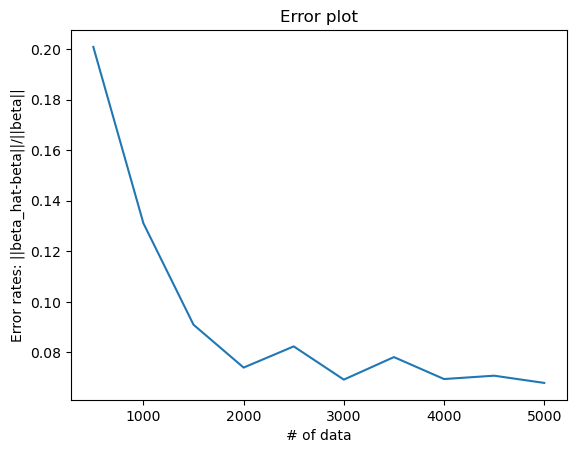

In [7]:
import matplotlib.pyplot as plt

# assuming n_list and err_list are already defined
plt.plot(n_list, err_rate_list)
plt.xlabel('# of data')
plt.ylabel('Error rates: ||beta_hat-beta||/||beta||')
plt.title('Error plot')
plt.show()

According to this plot, the relative error rate tends to converge to zero as $n$ (the number of data) goes large.So there is some clue that with enough data ($n$ large enough) the estimated $\hat \beta$ approaches the true $\beta$.

### Exercise 2 (Regression and OLS) (35 pts, 5 pts each)

Consider the regression setting in which $x_i \in \mathbb R^p$ and $y_i \in \mathbb R$, for $i=1,\ldots,n$ and $p < n$.

1. For a given regressor, let $\hat y_i$ be prediction given $x_i$, and $\hat y$ be the vector form.  Show that linear regression can be written in the form
$$
\hat y = H y,
$$
where $H$ is dependent on $X$ (the matrix of where each row is $x_i$), assuming that $p < n$ and $X$ is full rank.  Give an expression for $H$ or an algorithm for computing $H$. 
2. Assuming $p < n$ and $X$ is full rank, let $X = U D V^\top$ be the thin singular value decomposition where $U$ is $n \times p$, and $V, D$ is $p \times p$ ($D$ is diagonal). 
    - a) Derive an expression for the OLS coefficients $\hat\beta = A b$ such that $A$ is $p \times p$ and depends on $V$ and $D$, and $b$ is a $p$ vector and does not depend on $D$.   
    - b) Describe a fit method that precomputes these quantities separately
    - c) Use the simulated data $y$ and $X$ in below to find $\hat \beta$ using SVD.
    - d) Call a new data $\tilde X \in \mathbb{R}^{m \times p}$, derive an expression for the predicted $y$ with $\tilde X$ using SVD. 
3. Consider a regressor that performs OLS using the SVD above, but every instance of D will only use the largest $r$ values on the diagonal, the remainder will be set to 0.  Call this new $p \times p$ matrix $D_r$ ($r < p$).  Then the new coefficient vector is the OLS computed as if the design matrix is modified by $X \gets U D_r V^\top$.  
    - a) Given that you have computed $b$ already, how could you make a method `change_rank` that recomputes $A$ with $D_r$ instead of $D$? 
    - b) Choose $r = 10$, recompute $\hat\beta$ (call it $\hat\beta_{\text{LowRank}}$) in Question 2-c.

**Ans 1.**

*Proof.*

The OLS problem:
$$\min_\beta||Y-X\beta||_2^2$$

$$\Rightarrow\frac{\partial}{\partial \beta}||Y-X\beta||_2^2=\frac{\partial}{\partial \beta}(Y-X\beta)'(Y-X\beta)=-2X'(Y-X\beta)\overset{\text{Let}}=\bf {0}$$

$$\Rightarrow X'Y=(X'X)\widehat \beta_{OLS}\Rightarrow \widehat \beta_{OLS}=(X'X)^{-1}X'Y$$

$$\Rightarrow \widehat Y=X\widehat \beta_{OLS}=X(X'X)^{-1}X'Y=HY$$

where $H\triangleq X(X'X)^{-1}X'$.

Here is the code to compute **H**:

> H = X @ np.linalg(X.T @ X) @ X.T

**Ans 2.**

*a)* $$\widehat \beta = (X'X)^{-1}X'Y=(VDU'UDV')^{-1}VDU'Y=(VD^2V')^{-1}VDU'Y=Ab$$

where $A\triangleq (VD^2V')^{-1}VD$, $b\triangleq U'Y\perp \!\!\! \perp V,D$.

*b)*  **And** *c)*

Honestly, I get confused with what exactly I need to do in these parts. Pardon me for merging them together. 

In [8]:
## Simulate from the linear regression model (use y,X)
np.random.seed(2022)
n, p = 100,20
X = np.random.normal(0,1,size = (n,p))
beta = np.random.normal(0,.2,size = (p))
sigma = 1
y = np.random.normal(X @ beta, sigma**2)

In [9]:
np.linalg.matrix_rank(X) # X is full rank

20

In [10]:
# Precompute according to the above formula
u, s, vh = np.linalg.svd(X, full_matrices=True)
U, D, V = u[:,0:X.shape[1]], np.diag(s), vh.T
# Trivial version
A = np.linalg.inv(V @ D ** 2 @ V.T ) @ V @ D
b = U.T @ y
beta_hat = A @ b

In [11]:
# Faster way to precompute these things
VD = V * s
A = np.linalg.inv(VD @ VD.T) @ VD
b = U.T @ y
beta_hat = A @ b

d) $$\widehat Y=\tilde X\widehat\beta=\tilde XAb$$

where $A\triangleq (VD^2V')^{-1}VD$, $b\triangleq U'Y$.

**Ans 3.**

*a)*

$$\tilde A=((VD_r)(VD_r)')^{-1}VD_r$$

In [12]:
def change_rank(V, s, r):
    """
    Input:
        V: np.array [nxn]
        s: np.array [nx1]
        r: int
        
    Output:
        Ar: (VDr**2V')^-1VDr
            where Dr = diag(s[:r] 0...0)
    """
    import numpy as np
    from copy import deepcopy
    s_r = deepcopy(s)
    s_r[r:] = 0
    VDr = V * s_r
    Ar = np.linalg.inv(VDr @ VDr.T) @ VDr
    return Ar, s_r

*b)*

In [13]:
Ar, s_r = change_rank(V, s, r=10)
beta_hat_lowrank = Ar @ b

### Exercise 3 (Subset selection)  (20 pts, 5 each)

Recall the subset selection problem with tuning parameter $k$,
$$
\min_{\beta : \| \beta \|_0 \le k}\| y - X \beta \|_2^2,
$$
where $\|\beta\|_0 = \#\{j = 1\,\ldots,p : \beta_j \ne 0 \}$.

Notice that we can write this as 
$$
\min_{\beta : |{\rm supp}(\beta)| \le k}\| y - X \beta \|_2^2,
$$
where 
${\rm supp}(\beta) = \{j = 1\,\ldots,p : \beta_j \ne 0 \}$ (${\rm supp}(\beta)$ is the support of $\beta$).

1. Write the subset selection problem in the following form
$$
\min_{S \subseteq \{1,\ldots,p\}, |S|\le k} y^\top P_S y,
$$
where $P_S$ is a projection.  
2. Suppose that we have a nested sequence of models $S_1\subset S_2 \subset \ldots \subset S_p$ such that $|S_k| = k$ ($|S_k|$ is the cardinality of $S_k$, meaning that it contains $k$ variables).  Prove that $$y^\top P_{S_k} y \ge y^\top P_{S_{k+1}}\ \ y$$ for $k=1,\ldots,p-1$.  What does this tell us about the solution to the subset selection problem and the constraint $|S| \le k$?

    (Hint: using the fact that $X^TX$ is positive definite, write $X^TX= VD^2V^T$)

3. Suppose that $X$ is orthogonal, then write a computationally efficient pseudocode to solve the subset selection problem.  Prove that it is correct (your algorithm actually solves subset selection under othogonal design).
4. (Challenge) Suppose that we have that $n = p$ and $y_i = \beta_i + \epsilon_i$ (identity design matrix) where $\epsilon_i$ satisfies 
$$
\mathbb P \left\{ |\epsilon_i| \ge t \right\} \le 2 e^{-t^2 / 2\sigma^2}
$$
for any $t > 0$ (this is true for central Normal RVs) for some $\sigma > 0$.
Suppose that there is some true $S_0 \subset\{1,\ldots,p\}$ such that $|S_0| = k < p$ and ${\rm supp}(\beta) = S_0$.
Prove the following.

__Proposition__
Define $\mu = \min_{j \in S_0} |\beta_j|$ and call $\mu / \sigma$ the signal-to-noise ratio.  Then if 
$$
\frac{\mu}{\sigma} > 2 \sqrt{2 \log \left( \frac{2n}{\delta}\right)},
$$
then the true $S$ is selected by subset selection with probability at least $1 - \delta$.

Hint: rewrite the subset selection problem with $X = I$ and compare the objective at $S_0$ to any other $S$.

**Ans 1.** 

$$
\min_{\beta : \| \beta \|_0 \le k}\| y - X \beta \|_2^2
\Leftrightarrow
\min_{S \subseteq \{1,\ldots,p\}, |S|\le k,\beta_S\in \mathbb{R}^k} ||y - X_{\cdot,S}\ \beta_S \|_2^2
$$

where $(X_{\cdot,S})_i=X_{\cdot,S_i} \ \forall i\in\{k\}$.


For fixed support set $S$, $\widehat\beta_S=\arg\min_{\beta_S\in \mathbb{R}^k} ||y - X_{\cdot,S}\ \beta_S \|_2^2=X_{\cdot,S}(X_{\cdot,S}'X_{\cdot,S})^{-1}X_{\cdot,S}y=H_S y$, where $H_S\triangleq X_{\cdot,S}(X_{\cdot,S}'X_{\cdot,S})^{-1}X_{\cdot,S}$.

It is easy to see that:

* $(I-H_S)'=I-H_S$,

* $(I-H_S)^2=I+H_S^2-2H_S=I+H_S-2H_S=I-H_S$.

So $P_S\triangleq (I-H_S)$ is a projection matrix. Obviously, $y'P_S'P_Sy=y'P_Sy$.

So $$
\min_{\beta : \| \beta \|_0 \le k}\| y - X \beta \|_2^2
\Leftrightarrow 
\min_{S \subseteq \{1,\ldots,p\}, |S|\le k} ||(I-H_S)y||_2^2
\Leftrightarrow
\min_{S \subseteq \{1,\ldots,p\}, |S|\le k} y'P_Sy
$$

where $P_S=I-H_S=I-X_{\cdot,S}(X_{\cdot,S}'X_{\cdot,S})^{-1}X_{\cdot,S}$, and $(X_{\cdot,S})_i=X_{\cdot,S_i} \ \forall i\in\{k\}$.

**Ans 2.** **My provement is a little bit long. Thanks for your patience!**

Denote $H_{i}\triangleq X_{S_{i}}\ (X_{S_{i}}'\ X_{S_{i}}\ )^{-1}X_{S_{i}}'$, $P_{i}\triangleq 1 - H_{i}\ \ \forall i=1,2,\cdots,p$.

$\forall k\in\{p-1\}$, WLOG, I can suppose $X_{S_{k+1}}=\begin{pmatrix} X_{S_k}&x \end{pmatrix}$.

Denote $H_x\triangleq x(x'x)^{-1}x'$, $P_x\triangleq 1-H_x$.

So 
$$
\begin{aligned}
&H_{k+1}
\\=&
    \begin{pmatrix} X_{S_k}&x\end{pmatrix}
    \begin{pmatrix}
        X_{S_k}'X_{S_k}      & X_{S_k}'x\\
        x'X_{S_k}          & x'x
    \end{pmatrix}^{-1}
    \begin{pmatrix}
        X_{S_k}'\\
        x'
    \end{pmatrix}
\\=&
    \begin{pmatrix} 
        X_{S_k}     &    x
    \end{pmatrix}
    \begin{pmatrix}
       ( X_{S_k}'X_{S_k} -   X_{S_k}'x   (x'x)^{-1}   x'X_{S_k}   )^{-1}        &     0\\
       0  &     (     x'x    -   x'X_{S_k}  (X_{S_k}'X_{S_k} )^{-1}   X_{S_k}'x     )^{-1}
    \end{pmatrix}
        \begin{pmatrix}
            I    &   -  X_{S_k}'x  (x'x)^{-1}\\
            -  x'X_{S_k} (  X_{S_k}'X_{S_k}  )^{-1}   &   I
        \end{pmatrix}
    \begin{pmatrix}
    X_{S_k}'\\
    x'
    \end{pmatrix}
\end{aligned}
$$


So 
$$
\begin{aligned}
&H_{k+1}
\\=&
    \begin{pmatrix} 
        X_{S_k}  &    x
    \end{pmatrix}
    \begin{pmatrix}
       ( X_{S_k}'X_{S_k} -   X_{S_k}'x   (x'x)^{-1}   x'X_{S_k}   )^{-1}        &     0\\
       0  &     (     x'x    -   x'X_{S_k}  (X_{S_k}'X_{S_k} )^{-1}   X_{S_k}'x     )^{-1}
    \end{pmatrix}
    \begin{pmatrix}
        X_{S_k}'    +   -  X_{S_k}'x  (x'x)^{-1}x'\\
        -  x'X_{S_k} (  X_{S_k}'X_{S_k}  )^{-1} X_{S_k}'  +   x'
    \end{pmatrix}
\\=&
    \begin{pmatrix} 
        X_{S_k}  &    x
    \end{pmatrix}
    \begin{pmatrix}
       ( X_{S_k}'X_{S_k} -   X_{S_k}'x   (x'x)^{-1}   x'X_{S_k}   )^{-1}        &     0\\
       0  &     (     x'x    -   x'X_{S_k}  (X_{S_k}'X_{S_k} )^{-1}   X_{S_k}'x     )^{-1}
    \end{pmatrix}
    \begin{pmatrix}
        X_{S_k}' (I      -  x  (x'x)^{-1}x')\\
        x' (I-  X_{S_k} (  X_{S_k}'X_{S_k}  )^{-1} X_{S_k}')   
    \end{pmatrix}
\\=&
    \begin{pmatrix}
       X_{S_k}\bigg( X_{S_k}'X_{S_k} -   X_{S_k}'x   (x'x)^{-1}   x'X_{S_k}   \bigg)^{-1}        & x\bigg(     x'x    -   x'X_{S_k}  (X_{S_k}'X_{S_k} \bigg)^{-1}   X_{S_k}'x     )^{-1}
    \end{pmatrix}
    \begin{pmatrix}
        X_{S_k}' (I      -  x  (x'x)^{-1}x')\\
        x' (I-  X_{S_k} (  X_{S_k}'X_{S_k}  )^{-1} X_{S_k}')   
    \end{pmatrix}
\\=&
       X_{S_k}\bigg( X_{S_k}'X_{S_k} -   X_{S_k}'x   (x'x)^{-1}   x'X_{S_k}   \bigg)^{-1}X_{S_k}' (I      -  x  (x'x)^{-1}x')     
\\&+        
\\& 
       x\bigg(     x'x    -   x'X_{S_k}  (X_{S_k}'X_{S_k} )^{-1}   X_{S_k}'x     \bigg)^{-1}x' (I-  X_{S_k} (  X_{S_k}'X_{S_k}  )^{-1} X_{S_k}')
\end{aligned}
$$


So 

\begin{aligned}
&H_{k+1}
\\=&
       X_{S_k}\bigg( X_{S_k}'X_{S_k} -   X_{S_k}'x   (x'x)^{-1}   x'X_{S_k}   \bigg)^{-1}X_{S_k}' (I      -  x  (x'x)^{-1}x')     
    \\&+        
    \\& 
       x\bigg(     x'x    -   x'X_{S_k}  (X_{S_k}'X_{S_k} )^{-1}   X_{S_k}'x     \bigg)^{-1}x' (I-  X_{S_k} (  X_{S_k}'X_{S_k}  )^{-1} X_{S_k}')
\\=&
       X_{S_k}
       \bigg[
           ( X_{S_k}'X_{S_k} )^{-1}   
           +   
           ( X_{S_k}'X_{S_k} )^{-1}   
               X_{S_k}'x   \bigg(  x'x    -  x'X_{S_k}   ( X_{S_k}'X_{S_k} )^{-1}   X_{S_k}'x )^{-1}  x'X_{S_k} 
           ( X_{S_k}'X_{S_k} \bigg)^{-1}
       \bigg]
       X_{S_k}' (I      -  x  (x'x)^{-1}x')     
    \\&+        
    \\& 
       x\bigg(     x'x    -   x'X_{S_k}  (X_{S_k}'X_{S_k} )^{-1}   X_{S_k}'x     \bigg)^{-1}x' (I-  X_{S_k} (  X_{S_k}'X_{S_k}  )^{-1} X_{S_k}')
\\=&
           X_{S_k}  ( X_{S_k}'X_{S_k} )^{-1}   X_{S_k}' (I      -  x  (x'x)^{-1}x') 
    \\&+  
           X_{S_k}  ( X_{S_k}'X_{S_k} )^{-1}   
               X_{S_k}'x   \bigg(  x'x    -  x'X_{S_k}   ( X_{S_k}'X_{S_k} )^{-1}   X_{S_k}'x \bigg)^{-1}  x'X_{S_k} 
           ( X_{S_k}'X_{S_k} )^{-1}  X_{S_k}' (I      -  x  (x'x)^{-1}x')   
    \\&+        
    \\& 
       x
       \bigg(     x'x    -   x'X_{S_k}  (X_{S_k}'X_{S_k} )^{-1}   X_{S_k}'x     \bigg)^{-1}
       x' (I-  X_{S_k} (  X_{S_k}'X_{S_k}  )^{-1} X_{S_k}')
\\=&
       [
           H_k (I      -  H_x) 
    \\&+  
           H_k  x(  x'x    -  x'  H_k   x )^{-1}  x'  H_k (I      -  H_x)   
       ] 
    \\&+        
    \\& 
       x
       (     x'x    -   x'  H_k  x     )^{-1}
       x' (I-  H_k)
\\=&
    H_k+(I-H_k)x(x'(I-H_k)x)^{-1}(I-H_k)
    \\&+
        H_k x(x'x-x'H_k x)^{-1}x'
    \\&-
        H_k x(x'x)^{-1}x'    
    \\&-
        H_k x(x'x-x'H_k x)^{-1}x'H_k x(x'x)^{-1}x'
\\=&
    H_k+(I-H_k)x(x'(I-H_k)x)^{-1}(I-H_k)
\\=&
    H_k+P\{P_k x\}
\end{aligned}



where $P\{M\}\triangleq M(M'M)^{-1}M^{-1}$ is the projection matrix onto the column space of matrix $M$ $\forall$ full rank matrix $M$. So $P\{M\}\succeq 0$.

Here hides the fact that $(A'A-A'BA)((A'A)^{-1}+(A'A-A'BA)^{-1}A'BA(A'A)^{-1})=I-A'BA(A'A)^{-1}+A'BA(A'A)^{-1}=I \ \ \forall$ full rank matrices $ A, B$, so $(A'A-A'BA)^{-1}=((A'A)^{-1}+(A'A-A'BA)^{-1}A'BA(A'A)^{-1})$, and therefore I have 
    $$
        H_k x(x'x-x'H_k x)^{-1}x'
    -
        H_k x(x'x)^{-1}x'    
    -
        H_k x(x'x-x'H_k x)^{-1}x'H_k x(x'x)^{-1}x'=        H_k x[(x'x-x'H_k x)^{-1}-(x'x)^{-1}-(x'x-x'H_k x)^{-1}x'H_k x(x'x)^{-1}]x'
    =0$$.

You'll see that throughout my whole proof, I treated every component as a matrix rather than making use of the fact that $x'x$ and $x'H_k x$ are scale values. So the conclusion could be naturly generalized to matrix form:
$$P\{X\}=P\{A\}+P\{(I-P\{A\})B\}\ \ \forall \text{full rank matrix}\  X$$

where $X\triangleq\begin{pmatrix}A & B \end{pmatrix}$, $P\{X\}\triangleq X(X'X)^{-1}X'$ is the projection matrix onto the column space of matrix $X$.

So $P\{X\}-P\{A\}=P\{(I-P\{A\})B\}\succeq 0$.

Thus, we have a more convenient way to prove the whole thing at the cost of some more innocent assuptions WLOG, but let us get back to the normal track:

$$y'P_{S_k}y-y'P_{S_{k+1}\ \ }y=y'(P_{S_k}-P_{S_{k+1}}\ \ )y=y'(H_{k+1}-H_{k})y=y'(P\{P_k x\})y\ge 0\ \ \forall y\in \mathbf{R}^n$$.

This result tells us that for any subset sequence, the more columns of the data matrix $X$ we selected, the no larger the loss function could be.

Here is the second way to prove this result: 

WLOG, define $X_{S_{k+1}}\triangleq(X_{S_k}\ \ x)$ and $H_\Delta\triangleq H_{S_{k+1}}\ -H_{S_{k}}$. Notice that $H_{S_{k+1}}\ X_{S_{k}}
=H_{S_{k+1}}\ X_{S_{k+1}}\begin{pmatrix}I_{|S_k|}\\\textbf{0}\end{pmatrix}
=X_{S_{k+1}}\begin{pmatrix}I_{|S_k|}\\\textbf{0}\end{pmatrix}
=X_{S_k}\Rightarrow H_{S_{k+1}}\ H_{S_k}=H_{S_k}$. 

Therefore, it is easy to prove that 
$H_\Delta=H_\Delta'$ and 
$
H_\Delta^2
=H_{S_{k+1}}^2+H_{S_k}^2-H_{S_{k+1}}\ H_{S_k}-H_{S_{k}}H_{S_{k+1}}\ 
=H_{S_{k+1}}\ +H_{S_k}-2H_{S_k}
=H_\Delta
$. 
It means $H_\Delta$ is a projection matrix. 
So $H_\Delta\succeq 0$, 
and $y'P_{S_k}y-y'P_{S_{k+1}}\ y'H_{\Delta}y\ge 0\ \forall y\in\mathbf{R}^n$.

**Ans 3.**

Since $X_{\cdot,i}'X_{\cdot,j}=\delta_{ij}\triangleq \textbf{1}\{i=j\}\ \ \forall i,j\in\{p\}\triangleq\{1,2,\cdots,p\}$, $p$ is the number of columns of $X$,

then $X_S'X_S=I_{|S|}\Rightarrow H_S\triangleq X_S(X_S'X_S)^{-1}X_S'=X_SX_S'\Rightarrow y'H_Sy=||X_S'y||_2^2=\sum_{i\in S}(X'y)_i^2\le \sum_{l\in\{|S|\}}(X'y)_{i_l}^2$ , 

where $z_{i_1}^2\ge z_{i_2}^2\ge\cdots\ge z_{i_p}^2$, $\{i_l\}_{l=1}^p=\{p\}$, $z_i\triangleq (X'y)_i \forall i\in\{p\}$.

So $\min_{|S|\le k}y'P_Sy=\min_{|S|\le k}(y'y-y'H_Sy)=\max_{|S|\le k}(y'H_Sy)=\max_{|S|\le k}\sum_{l\in\{|S|\}}(X'y)_{i_l}^2=\sum_{l\in\{k\}}(X'y)_{i_l}^2$ ,

where $z_{i_1}^2\ge z_{i_2}^2\ge\cdots\ge z_{i_p}^2$, $\{i_l\}_{l=1}^p=\{p\}$, $z_i\triangleq (X'y)_i \forall i\in\{p\}$.

Therefore, $S$ is the index set comprising the subindices that correspond to the $k$ largest values of $|X'y|$.

Here is the corresponding pseudocode code:

---
**Algorithm** subset_select_on_orthogonal:

**Input**: orthogonal matrix $X\in\mathbf{R}^{n\times p}$, vector $y\in \mathbf{R}$, and a constant scale $k$, the maximum size of index set $S$.

**Output**: the optimal index set $S$ that satifies $|S|\le k$.

1. $z = |X'y|$

2. $S = \{ i| z_i $ is the largest $i$-th entry of $ z, i\le k  \}$

---

Here is the Python code:

In [14]:
def subset_select_on_orthogonal(X_orthogonal, y, set_size):
    k = set_size
    z = X_orthogonal.T @ y
    z_abs = abs(z)# z_abs = |X'y| now
    S = np.argsort(z_abs)[-k:] # np.argsort returns the indices that would sort an array. 
    # [-k:] is to take the subindices that correspond to the  𝑘 largest values of  |𝑋′𝑦|
    return S

In [15]:
import numpy as np
from scipy.stats import ortho_group

# Set the random seed to 2023
np.random.seed(2023)

row_length = 9
# Generate a random orthogonal matrix
X = ortho_group.rvs(dim=row_length)

# Generate a random vector
y = np.random.rand(row_length)

# Set maximum size of the subindice set
set_size = 5

# Calculate the best subindice set
S = subset_select_on_orthogonal(X,y,set_size)

S

array([3, 1, 5, 2, 4], dtype=int64)

In [16]:
# Verify the correctness of the result
z = abs(X.T @ y)
z

array([0.23849965, 0.83877248, 0.84763553, 0.81091195, 0.91112095,
       0.84241894, 0.02617022, 0.09571838, 0.0585945 ])

In [17]:
np.argsort(z)

array([6, 8, 7, 0, 3, 1, 5, 2, 4], dtype=int64)

In [18]:
z[np.argsort(z)]

array([0.02617022, 0.0585945 , 0.09571838, 0.23849965, 0.81091195,
       0.83877248, 0.84241894, 0.84763553, 0.91112095])

**Ans 4.**

We know that $
\frac{\mu}{\sigma} > 2 \sqrt{2 \log \left( \frac{2n}{\delta}\right)}
\\\Leftrightarrow
\frac{1}{\sqrt{2}}\frac{\mu / 2}{\sigma}>
\sqrt{\log(\frac{2n}{\delta})}
\\\Leftrightarrow
\frac{1}{2}(\frac{\mu / 2}{\sigma})^2 >
\log (\frac{2n}{\delta})
\\\Leftrightarrow
\exp\{\frac{1}{2}(\frac{\mu / 2}{\sigma})^2 \}>
\frac{2n}{\delta}
\\
\Leftrightarrow
\exp\{\frac{-1}{2}(\frac{\mu / 2}{\sigma})^2 \}\le
\frac{\delta}{2n}
\\
\Leftrightarrow
2n \exp\{\frac{-1}{2}(\frac{\mu / 2}{\sigma})^2 \}\le
\delta
\\
\Leftrightarrow
1-2n \exp\{\frac{-1}{2}(\frac{\mu / 2}{\sigma})^2 \}>
1-\delta
$

And that $
P\{|\epsilon_i| \ge t,\exists i\in\{p\}\}
\\=
\mathbb P\{\cup_{i=1}^p\{|\epsilon_i| \ge t\}\}
\\\le
\mathbb P \left\{ |\epsilon_1| \ge t \right\}+
\mathbb P \left\{ |\epsilon_2| \ge t \right\}+
\cdots+
\mathbb P \left\{ |\epsilon_p| \ge t \right\}
\le 2p e^{-t^2 / 2\sigma^2}
=2n e^{-t^2 / 2\sigma^2}
$

So $
P\{|\epsilon_i|<\mu/2\ \forall i\in\{p\}\}
\\=1-P\{|\epsilon_i| \ge \mu/2,\exists i\in\{p\}\}
> 1- 2n e^{-(\mu/2)^2 / 2\sigma^2}
\\>1-\delta$

WLOG, suppose $\beta_i\not=0,$ $i=1,2,\cdots,k$, i.e. $S_0=\{k\}\triangleq\{1,2,\cdots,k\}$. Define $S$ to be the set chosen by subset selection algorithm.

Therefore, 
$
P(S=S_0)
=
P\{|(\beta_S)_i|=|(X_S'y)_i|=|(y_S)_i|=|(y_{S_0})_i|>|(y_{ \{p\}\text{\ } S_0})_j|, i\in \{k\},\ \ j\in\{|S\text{\ } S_0|\}\}
\\=
P\{|\beta_i+\epsilon_i|>|\epsilon_j|, i=1,2,\cdots,k,\ \ j=k+1,k+2,\cdots,p\}
\\\ge
P\{\beta_i+\epsilon_i>|\epsilon_j|, i=1,2,\cdots,k,\ \ j=k+1,k+2,\cdots,p\}\text{[This is a sufficient condition for the above one]}
\\\ge
P\{\beta_i-|\epsilon_i|>|\epsilon_j|, i=1,2,\cdots,k,\ \ j=k+1,k+2,\cdots,p\}\text{[This is a sufficient condition for the above one]}
\\\ge
P\{\beta_i>2|\epsilon_j|, i=1,2,\cdots,k,\ \ j=1,2,\cdots,p\}\text{[This is a sufficient condition for the above one]}
\\=
P\{\mu=\min_{i\in\{k\}} |\beta_i|=\min_{i\in\{k\}} \beta_i>2|\epsilon_j|,\ j=1,2,\cdots,p\}
\\=
P\{|\epsilon_i|<\mu/2\ \forall i\in\{p\}\}
\\>
1-\delta.
$

### Exercise 4 (Ridge, lasso and adaptive lasso) (35 pts, 5 pts each)

For this exercise, it may be helpful to use the `sklearn.linear_model` module.  I have also included a plotting tool for making the lasso path in ESL.

1. Load the training and test data using the script below.  Fit OLS on the training dataset and compute the test error.  Throughout you do not need to compute an intercept but you should normalize the $X$ (divide by the column norms).
2. Ridge regression: Train and tune ridge regression using a validation set (choose LOOCV) and compute the test error (square error loss).
3. Fit the lasso path with lars to the data and compute the test error for each returned lasso coefficient.
4. Perform 3 without the lasso modification generating the lars path.  Compare and contrast the lars path to the lasso path, what is the key difference.  Comment on when the active sets differ and how, if they do at all.
5. Fit the lasso path with coordinate descent to the data. Compare the lasso path using coordinate descent with the path using lars. Comment on what you found.
6. Extract each active set from the lasso path and recompute the restricted OLS for each.  Compute and compare the test error for each model.
7. Read this website [click here](https://towardsdatascience.com/an-adaptive-lasso-63afca54b80d). Fit the adaptive lasso method to the data. Compare the test error between the adaptive lasso and lasso for each returned coefficient. Comment on what you found.

**Ans 1.**

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

In [20]:
def plot_lars(coefs, lines=False, title="Lars Path"):
    """
    Plot the lasso path where coefs is a matrix - the columns are beta vectors
    """
    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    if lines:
        plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title(title)
    plt.axis('tight')

In [21]:
import pickle
with open('hw1.data','rb') as f:
    y_tr,X_tr,y_te,X_te = pickle.load(f)

In [22]:
# Normalize X
X = np.concatenate((X_tr, X_te))
y = np.concatenate((y_tr, y_te))
X = normalize(X, axis=0)

X_tr = X[:1000, :]
X_te = X[1000:, :]

# Fit OLS
lm = LinearRegression(fit_intercept=False)
lm.fit(X_tr, y_tr)

# Compute test error
y_hat = lm.predict(X_te)
test_error_ols = np.sum((y_te-y_hat)**2)/len(y_hat)
print("Test error for OLS: {:.4f}".format(test_error_ols))

Test error for OLS: 1.0396


**Ans 2.** 

Train and tune ridge regression using a validation set (choose LOOCV) and compute the test error:

In [23]:
lamdas = np.linspace(0.001**3,0.001,200)
model_ridge = RidgeCV(alphas = lamdas, store_cv_values=True)
model_ridge.fit(X_tr, y_tr)
cv_vals = model_ridge.cv_values_
LOOridge = cv_vals.mean(axis=0)
lamda = lamdas[np.argmin(LOOridge)]
print('lambda: ', lamda)
print('min validation error: ', np.min(LOOridge))

lambda:  0.00024623190954773874
min validation error:  1.139043321613451


In [24]:
# Compute test error
y_te_pred_ridge = model_ridge.predict(X_te)
test_error_ridge = mean_squared_error(y_te, y_te_pred_ridge)
print("Test error for Ridge: {:.4f}".format(test_error_ridge))

Test error for Ridge: 1.0381


**Ans 3.** Fit the lasso path with lars to the data and compute the test error for each returned lasso coefficient.

In [25]:
from sklearn.linear_model import lars_path, lasso_path, Lasso
plot_range = range(40,60)
# Lasso with LARS
larlasso_path = lars_path(X_tr, y_tr, method='lasso')

In [26]:
# Compute test error for each Lasso coefficient
for i in plot_range:
    coef = larlasso_path[2][:,i]
    y_te_pred_lasso = X_te.dot(coef)
    test_error_lasso = mean_squared_error(y_te, y_te_pred_lasso)
    print("Test error for Lasso coefficient {}: {:.4f}".format(i, test_error_lasso))

Test error for Lasso coefficient 40: 1.0185
Test error for Lasso coefficient 41: 1.0147
Test error for Lasso coefficient 42: 1.0145
Test error for Lasso coefficient 43: 1.0121
Test error for Lasso coefficient 44: 1.0103
Test error for Lasso coefficient 45: 1.0076
Test error for Lasso coefficient 46: 1.0060
Test error for Lasso coefficient 47: 1.0060
Test error for Lasso coefficient 48: 1.0053
Test error for Lasso coefficient 49: 1.0036
Test error for Lasso coefficient 50: 1.0034
Test error for Lasso coefficient 51: 1.0033
Test error for Lasso coefficient 52: 1.0031
Test error for Lasso coefficient 53: 1.0017
Test error for Lasso coefficient 54: 1.0016
Test error for Lasso coefficient 55: 1.0012
Test error for Lasso coefficient 56: 1.0009
Test error for Lasso coefficient 57: 0.9988
Test error for Lasso coefficient 58: 0.9988
Test error for Lasso coefficient 59: 0.9986


**Ans 4.** Perform 3 without the lasso modification generating the lars path. Compare and contrast the lars path to the lasso path, what is the key difference. Comment on when the active sets differ and how, if they do at all.

In [27]:
# Perform 3 without the lasso modification generating the lars path.
lars_path = lars_path(X_tr, y_tr, method='lar')

In [28]:
# Compute test error for each Lasso coefficient
for i in plot_range:
    coef = lars_path[2][:,i]
    y_te_pred_lars = X_te.dot(coef)
    test_error_lars = mean_squared_error(y_te, y_te_pred_lars)
    print("Test error for LARS path without the lasso modification {}: {:.4f}".format(i, test_error_lars))

Test error for LARS path without the lasso modification 40: 1.0185
Test error for LARS path without the lasso modification 41: 1.0147
Test error for LARS path without the lasso modification 42: 1.0145
Test error for LARS path without the lasso modification 43: 1.0121
Test error for LARS path without the lasso modification 44: 1.0103
Test error for LARS path without the lasso modification 45: 1.0076
Test error for LARS path without the lasso modification 46: 1.0060
Test error for LARS path without the lasso modification 47: 1.0060
Test error for LARS path without the lasso modification 48: 1.0053
Test error for LARS path without the lasso modification 49: 1.0036
Test error for LARS path without the lasso modification 50: 1.0034
Test error for LARS path without the lasso modification 51: 1.0033
Test error for LARS path without the lasso modification 52: 1.0031
Test error for LARS path without the lasso modification 53: 1.0017
Test error for LARS path without the lasso modification 54: 1.

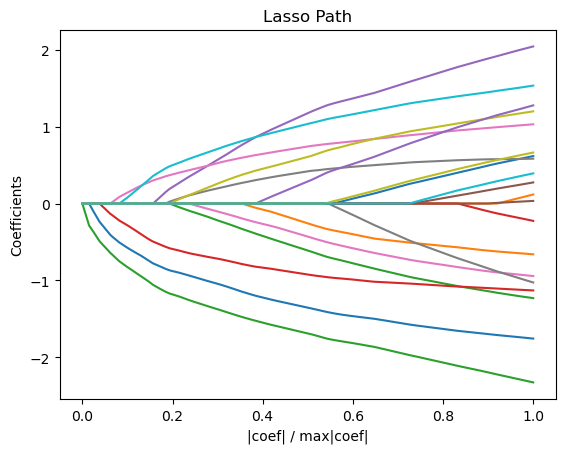

In [29]:
# Compare and contrast the lars path to the lasso path
plot_lars(larlasso_path[2][plot_range,:], lines=False, title="Lasso Path")

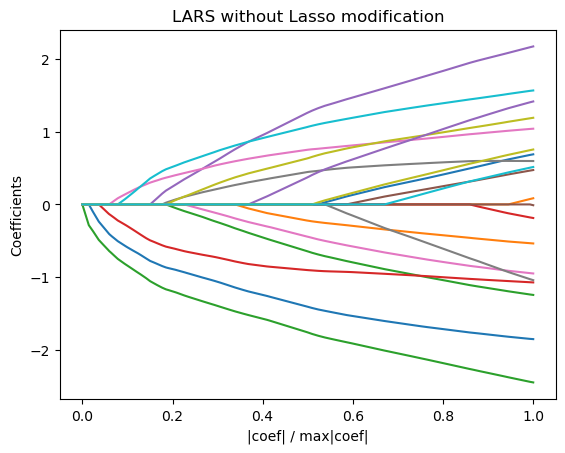

In [30]:
# Compare and contrast the lars path to the lasso path
plot_lars(lars_path[2][plot_range,:], lines=False, title="LARS without Lasso modification")

Lasso path and the lars path are quite similar. They get slightly different after `|coef|/max|coef|` gets larger than 0.5.

In [31]:
index_lars = (lars_path[2]!=0) * 1
index_lasso = (larlasso_path[2]!=0) * 1
index_lasso.shape, index_lars.shape

((100, 103), (100, 102))

In [32]:
for k in range(102):
    if np.sum(index_lasso[:, k] != index_lars[:, k]) > 0:
        print(k)
        break
# this tells us that the lasso path and lars path differs in the 71th path

70


In [33]:
index_lars[:, 70] != index_lasso[:, 70]
# this tells us that lasso drops the 4-th coefficient but lars doesn't drop it

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

**Ans 5.** Fit the lasso path with coordinate descent to the data. Compare the lasso path using coordinate descent with the path using lars. Comment on what you found.

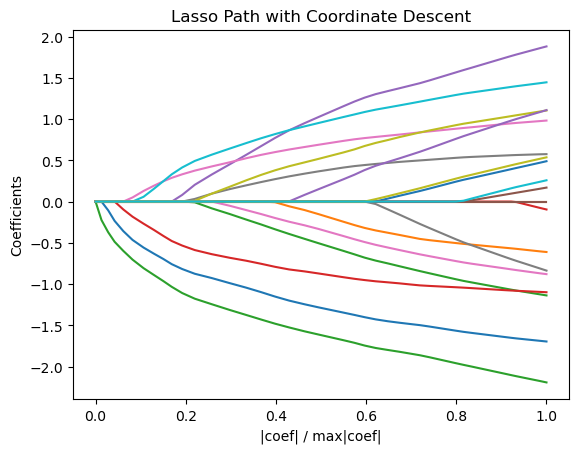

In [34]:
lasso_path = lasso_path(X_tr, y_tr)
plot_lars(lasso_path[1][plot_range,:], lines=False, title='Lasso Path with Coordinate Descent')

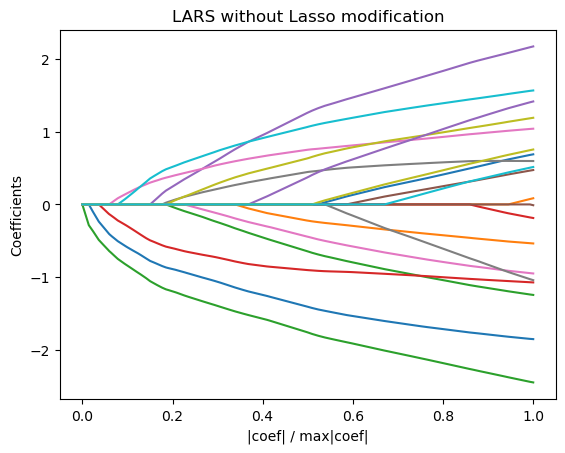

In [35]:
plot_lars(lars_path[2][plot_range,:], lines=False, title="LARS without Lasso modification")

In [36]:
index_lars = (lars_path[2]!=0) * 1
index_lasso_2 = (lasso_path[1]!=0) * 1
index_lasso_2.shape, index_lars.shape

((100, 100), (100, 102))

In [37]:
for k in range(100):
    if np.sum(index_lasso_2[:, k] != index_lars[:, k]) > 0:
        print(k)
        break
# this tells us that the lasso path and lars path differs in the 71th path

0


In [38]:
index_lars[:, 70] != index_lasso_2[:, 70]
# this tells us that lasso drops the 4-th coefficient but lars doesn't drop it

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False])

The lasso path using coordinate descent and the path using lars are also very silimar with eath other.

**Ans 6.** Extract each active set from the lasso path and recompute the restricted OLS for each. Compute and compare the test error for each model.

Below is the figure for test errors. The test error drops first but then increases drastically. When $\lambda$ is greater, more coefficients are to be dropped and the model could not predict well. The minimum test error happens when $\lambda=0.000949$ and $\widehat{err}=0.9844$.

In [39]:
error_resols = []
active_sets = lars_path[2]
for i in range(len(lars_path[0])):
    active_set = active_sets[:, i]
    X_restr = X_tr[:, np.where(active_set!=0)[0]]
    X_reste = X_te[:, np.where(active_set!=0)[0]]
    if np.sum(active_set!=0)==0:
        y_reshat = 0
    else:
        ols = LinearRegression(fit_intercept=False)
        ols.fit(X_restr, y_tr)
        y_reshat = ols.predict(X_reste)
    error_resols += [np.mean((y_reshat-y_te)**2)]

In [40]:
lars_path[0][np.argmin(error_resols)], min(error_resols)

(0.0009490267003594619, 0.9844499297178834)

In [41]:
np.where(index_lasso[:, np.argmin(error_resols)]==1)[0]

array([ 0,  1,  2,  3,  5,  8, 27, 38, 50, 52, 53, 68, 69, 76, 77, 78, 80,
       91, 96, 97], dtype=int64)

Text(0.5, 1.0, 'Restricted OLS Test Error for Lasso')

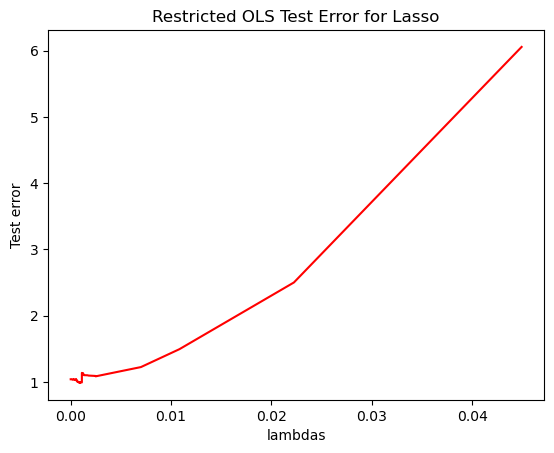

In [42]:
plt.plot(lars_path[0],error_resols, 'r', label='Test Error for Lasso')
plt.xlabel('lambdas')
plt.ylabel('Test error')
plt.title('Restricted OLS Test Error for Lasso')

### Exercise 4 (Ridge, lasso and adaptive lasso) (35 pts, 5 pts each)

For this exercise, it may be helpful to use the `sklearn.linear_model` module.  I have also included a plotting tool for making the lasso path in ESL.

6. Extract each active set from the lasso path and recompute the restricted OLS for each.  Compute and compare the test error for each model.
7. Read this website [click here](https://towardsdatascience.com/an-adaptive-lasso-63afca54b80d). Fit the adaptive lasso method to the data. Compare the test error between the adaptive lasso and lasso for each returned coefficient. Comment on what you found.

**Ans 7.** Read this website [click here](https://towardsdatascience.com/an-adaptive-lasso-63afca54b80d). Fit the adaptive lasso method to the data. Compare the test error between the adaptive lasso and lasso for each returned coefficient. Comment on what you found.

In [43]:
# Load packages
import numpy as np
import asgl

In [44]:
lambda1 = np.linspace(0.001**3,0.001,1800)
tvt_lasso = asgl.TVT(model='lm', penalization='lasso', lambda1=lambda1, parallel=True,
                     error_type='MSE', random_state=1, train_size=50, validate_size=25)
lasso_result = tvt_lasso.train_validate_test(x=X_tr, y=y_tr)

lasso_prediction_error = lasso_result['test_error']
lasso_betas = lasso_result['optimal_betas'][1:] # Remove intercept

In [45]:
tvt_alasso = asgl.TVT(model='lm', penalization='alasso', lambda1=lambda1, parallel=True,
                      weight_technique='lasso', 
                      error_type='MSE', random_state=1, 
                      train_size=50, validate_size=25)
alasso_result = tvt_alasso.train_validate_test(x=X_tr, y=y_tr)

alasso_prediction_error = alasso_result['test_error']
alasso_betas = alasso_result['optimal_betas'][1:] # Remove intercept

In [46]:
# Prediction error
print(f'Lasso error:{np.round(lasso_prediction_error, 3)}\nAdaptive lasso error:{np.round(alasso_prediction_error, 3)}')

#Lasso error:1.996
#Adaptive lasso error:1.634

Lasso error:1.996
Adaptive lasso error:1.634


The adaptive lasso method has a smaller error than the original one. But this result is not so stable. Try these different initial settings `lambda1 = np.linspace(0.001**3,0.001,3000)` and `lambda1 = np.linspace(0.001**3,0.001,300)`


For `lambda1 = np.linspace(0.001**3,0.001,3000)`, the result is:

In [47]:
lambda1 = np.linspace(0.001**3,0.001,3000)
tvt_lasso = asgl.TVT(model='lm', penalization='lasso', lambda1=lambda1, parallel=True,
                     error_type='MSE', random_state=1, train_size=50, validate_size=25)
lasso_result = tvt_lasso.train_validate_test(x=X_tr, y=y_tr)

lasso_prediction_error = lasso_result['test_error']
lasso_betas = lasso_result['optimal_betas'][1:] # Remove intercept

tvt_alasso = asgl.TVT(model='lm', penalization='alasso', lambda1=lambda1, parallel=True,
                      weight_technique='lasso', 
                      error_type='MSE', random_state=1, 
                      train_size=50, validate_size=25)
alasso_result = tvt_alasso.train_validate_test(x=X_tr, y=y_tr)

alasso_prediction_error = alasso_result['test_error']
alasso_betas = alasso_result['optimal_betas'][1:] # Remove intercept

# Prediction error
print(f'Lasso error:{np.round(lasso_prediction_error, 3)}\nAdaptive lasso error:{np.round(alasso_prediction_error, 3)}')

#Lasso error:1.996
#Adaptive lasso error:2.01

Lasso error:1.996
Adaptive lasso error:2.01


For `lambda1 = np.linspace(0.001**3,0.001,300)`, the result is:

In [48]:
lambda1 = np.linspace(0.001**3,0.001,300)
tvt_lasso = asgl.TVT(model='lm', penalization='lasso', lambda1=lambda1, parallel=True,
                     error_type='MSE', random_state=1, train_size=50, validate_size=25)
lasso_result = tvt_lasso.train_validate_test(x=X_tr, y=y_tr)

lasso_prediction_error = lasso_result['test_error']
lasso_betas = lasso_result['optimal_betas'][1:] # Remove intercept

tvt_alasso = asgl.TVT(model='lm', penalization='alasso', lambda1=lambda1, parallel=True,
                      weight_technique='lasso', 
                      error_type='MSE', random_state=1, 
                      train_size=50, validate_size=25)
alasso_result = tvt_alasso.train_validate_test(x=X_tr, y=y_tr)

alasso_prediction_error = alasso_result['test_error']
alasso_betas = alasso_result['optimal_betas'][1:] # Remove intercept

# Prediction error
print(f'Lasso error:{np.round(lasso_prediction_error, 3)}\nAdaptive lasso error:{np.round(alasso_prediction_error, 3)}')

#Lasso error:1.996
#Adaptive lasso error:3.37

Lasso error:1.996
Adaptive lasso error:3.37


Without further investigation on these result, I could find that

* Adaptive lasso method could have a smaller error than the original lasso method as long as it starts with well-chosen $\lambda$s

* Too smaller or to large $\lambda$s are all bad for adaptive lasso method. The performance of adaptive lasso method is sensitive to the initial setting.

* When compared with adaptive lasso method, the performance of Lasso method is much less sensitive to the initial settings.